# MadMiner physics tutorial (part 2A)

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In this second part of the tutorial, we'll generate events and extract the observables and weights from them. You have two options: In this notebook we'll do this at parton level, in the alternative part 2b we use Delphes.

## 0. Preparations

Before you execute this notebook, make sure you have a running installation of MadGraph.

In [1]:
import os
import logging
import numpy as np

from madminer.core import MadMiner
from madminer.lhe import LHEReader
from madminer.sampling import combine_and_shuffle
from madminer.plotting import plot_distributions
from particle import Particle

In [2]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

Please enter here the environment variable pointing to your MG5 installation folder.

In [3]:
mg_dir = os.getenv("MG_FOLDER_PATH")

## 1. Generate events

Let's load our setup:

In [4]:
miner = MadMiner()
miner.load("data/setup.h5")

16:39 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.
16:39 madminer.core        INFO    Found 2 parameters:
16:39 madminer.core        INFO       CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
16:39 madminer.core        INFO       CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
16:39 madminer.core        INFO    Found 6 benchmarks:
16:39 madminer.core        INFO       sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:39 madminer.core        INFO       w: CWL2 = 15.20, CPWL2 = 0.10
16:39 madminer.core        INFO       neg_w: CWL2 = -1.54e+01, CPWL2 = 0.20
16:39 madminer.core        INFO       ww: CWL2 = 0.30, CPWL2 = 15.10
16:39 madminer.core        INFO       neg_ww: CWL2 = 0.40, CPWL2 = -1.53e+01
16:39 madminer.core        INFO       morphing_basis_vector_5: CWL2 = 16.88, CPWL2 = 14.95
16:39 madminer.core        INFO    Found morphing setup with 6 components
16:39 madminer.core        INFO    Did not find 

In a next step, MadMiner starts MadGraph to generate events and calculate the weights. You can use `run()` or `run_multiple()`; the latter allows to generate different runs with different run cards and optimizing the phase space for different benchmark points. 

In either case, you have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` (or in the case of `run_all`, `sample_benchmarks`) option can be used to specify which benchmark should be used for sampling, i.e. for which benchmark point the phase space is optimized. If you just use one benchmark, reweighting to far-away points in parameter space can lead to large event weights and thus large statistical fluctuations. It is therefore often a good idea to combine a lot of events at the "reference hypothesis" (for us the SM) and smaller samples from other benchmarks that span the parameter space.


In [5]:
miner.run(
    sample_benchmark="sm",
    mg_directory=mg_dir,
    mg_process_directory="./mg_processes/signal1",
    proc_card_file="cards/proc_card_signal.dat",
    param_card_template_file="cards/param_card_template.dat",
    run_card_file="cards/run_card_signal_large.dat",
    log_directory="logs/signal",
    python_executable="python3",
)

16:39 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal.dat at ./mg_processes/signal1
16:39 madminer.core        INFO    Run 0
16:39 madminer.core        INFO      Sampling from benchmark: sm
16:39 madminer.core        INFO      Original run card:       cards/run_card_signal_large.dat
16:39 madminer.core        INFO      Original Pythia8 card:   None
16:39 madminer.core        INFO      Original config card:    None
16:39 madminer.core        INFO      Copied run card:         /madminer/cards/run_card_0.dat
16:39 madminer.core        INFO      Copied Pythia8 card:     None
16:39 madminer.core        INFO      Copied config card:      None
16:39 madminer.core        INFO      Param card:              /madminer/cards/param_card_0.dat
16:39 madminer.core        INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
16:39 madminer.core        INFO      Log file:                run_0.log
16:39 madminer.core        INFO    Creating pa

In [6]:
additional_benchmarks = ["w", "ww", "neg_w", "neg_ww"]

In [7]:
miner.run_multiple(
    sample_benchmarks=additional_benchmarks,
    mg_directory=mg_dir,
    mg_process_directory="./mg_processes/signal2",
    proc_card_file="cards/proc_card_signal.dat",
    param_card_template_file="cards/param_card_template.dat",
    run_card_files=["cards/run_card_signal_small.dat"],
    log_directory="logs/signal",
    python_executable="python3",
)

16:52 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal.dat at ./mg_processes/signal2
16:52 madminer.core        INFO    Run 0
16:52 madminer.core        INFO      Sampling from benchmark: w
16:52 madminer.core        INFO      Original run card:       cards/run_card_signal_small.dat
16:52 madminer.core        INFO      Original Pythia8 card:   None
16:52 madminer.core        INFO      Original config card:    None
16:52 madminer.core        INFO      Copied run card:         /madminer/cards/run_card_0.dat
16:52 madminer.core        INFO      Copied Pythia8 card:     None
16:52 madminer.core        INFO      Copied config card:      None
16:52 madminer.core        INFO      Param card:              /madminer/cards/param_card_0.dat
16:52 madminer.core        INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
16:52 madminer.core        INFO      Log file:                run_0.log
16:52 madminer.core        INFO    Creating par

This will take a moment -- time for a coffee break!

After running any event generation through MadMiner, you should check whether the run succeeded: are the usual output files there, do the log files show any error messages? MadMiner does not (yet) perform any explicit checks, and if something went wrong in the event generation, it will only notice later when trying to load the event files.

### Backgrounds

We can also easily add other processes like backgrounds. An important option is the `is_background` keyword, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

To reduce the runtime of the notebook, the background part is commented out here. Feel free to activate it and let it run during a lunch break.

In [8]:
"""
miner.run(
    is_background=True,
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/background',
    proc_card_file='cards/proc_card_background.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_background.dat',
    log_directory='logs/background',
)
"""

u"\nminer.run(\n    is_background=True,\n    sample_benchmark='sm',\n    mg_directory=mg_dir,\n    mg_process_directory='./mg_processes/background',\n    proc_card_file='cards/proc_card_background.dat',\n    param_card_template_file='cards/param_card_template.dat',\n    run_card_file='cards/run_card_background.dat',\n    log_directory='logs/background',\n)\n"

Finally, note that both `MadMiner.run()` and `MadMiner.run_multiple()` have a `only_create_script` keyword. If that is set to True, MadMiner will not start the event generation directly, but prepare folders with all the right settings and ready-to-run bash scripts. This might make it much easier to generate Events on a high-performance computing system. 

## 2. Prepare analysis of the LHE samples

The `madminer.lhe` submodule allows us to extract observables directly from the parton-level LHE samples, including an approximate description of the detector response with smearing functions. The central object is an instance of the `LHEProcessor` class, which has to be initialized with a MadMiner file:

In [9]:
lhe = LHEReader("data/setup.h5")

17:03 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.


After creating the `LHEReader` object, one can add a number of event samples (the output of running MadGraph in step 1) with the `add_sample()` function.

In addition, you have to provide the information which sample was generated from which benchmark with the `sampled_from_benchmark` keyword, and set `is_background=True` for all background samples.

In [10]:
lhe.add_sample(
    lhe_filename="mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz",
    sampled_from_benchmark="sm",
    is_background=False,
    k_factor=1.0,
)
for i, benchmark in enumerate(additional_benchmarks):
    lhe.add_sample(
        lhe_filename="mg_processes/signal2/Events/run_0{}/unweighted_events.lhe.gz".format(i + 1),
        sampled_from_benchmark=benchmark,
        is_background=False,
        k_factor=1.0,
    )

"""
lhe.add_sample(
    lhe_filename='mg_processes/background/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark='sm',
    is_background=True,
    k_factor=1.0,
)
"""

17:03 madminer.lhe         DEBUG   Adding event sample mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz
17:03 madminer.lhe         DEBUG   Adding event sample mg_processes/signal2/Events/run_01/unweighted_events.lhe.gz
17:03 madminer.lhe         DEBUG   Adding event sample mg_processes/signal2/Events/run_02/unweighted_events.lhe.gz
17:03 madminer.lhe         DEBUG   Adding event sample mg_processes/signal2/Events/run_03/unweighted_events.lhe.gz
17:03 madminer.lhe         DEBUG   Adding event sample mg_processes/signal2/Events/run_04/unweighted_events.lhe.gz


u"\nlhe.add_sample(\n    lhe_filename='mg_processes/background/Events/run_01/unweighted_events.lhe.gz',\n    sampled_from_benchmark='sm',\n    is_background=True,\n    k_factor=1.0,\n"

## 3. Smearing functions to model the detector response

Now we have to define the smearing functions that are used (in lieu of a proper shower and detector simulation). Here we will assume a simple 10% uncertainty on the jet energy measurements and a $\pm 0.1$ smearing for jet $\eta$ and $\phi$. The transverse momenta of the jets are then derived from the smeared energy and the on-shell condition for the quarks (this is what `pt_resolution_abs=None` does). The photons from the Higgs are assumed to be measured perfectly (otherwise we'd have to call `set_smearing` another time with `pdgis=[22]`).

In [11]:
# Partons giving rise to jets
particles = [
    *Particle.findall(lambda p: p.pdgid.is_quark),
    *Particle.findall(pdg_name="g"),
]

lhe.set_smearing(
    pdgids=[int(p.pdgid) for p in particles],
    energy_resolution_abs=0.0,
    energy_resolution_rel=0.1,
    pt_resolution_abs=None,
    pt_resolution_rel=None,
    eta_resolution_abs=0.1,
    eta_resolution_rel=0.0,
    phi_resolution_abs=0.1,
    phi_resolution_rel=0.0,
)

In addition, we can define noise that only affects MET. This adds Gaussian noise with mean 0 and std `abs_ + rel * HT` to MET_x and MET_y separately.

In [12]:
lhe.set_met_noise(abs_=10.0, rel=0.05)

## 4. Observables and cuts

The next step is the definition of observables, either through a Python function or an expression that can be evaluated. Here we demonstrate the latter, which is implemented in `add_observable()`. In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

All of these represent objects inheriting from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

`add_observable()` has an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In a realistic project, you would want to add a large number of observables that capture all information in your events. Here we will just define two observables, the transverse momentum of the leading (= higher-pT) jet, and the azimuthal angle between the two leading jets.

In [13]:
lhe.add_observable(
    "pt_j1",
    "j[0].pt",
    required=False,
    default=0.0,
)
lhe.add_observable(
    "delta_phi_jj",
    "j[0].deltaphi(j[1]) * (-1.0 + 2.0 * float(j[0].eta > j[1].eta))",
    required=True,
)
lhe.add_observable(
    "met",
    "met.pt",
    required=True,
)

17:03 madminer.lhe         DEBUG   Adding optional observable pt_j1 = j[0].pt with default 0.0
17:03 madminer.lhe         DEBUG   Adding required observable delta_phi_jj = j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))
17:03 madminer.lhe         DEBUG   Adding required observable met = met.pt


We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [14]:
lhe.add_cut("(a[0] + a[1]).m > 122.0")
lhe.add_cut("(a[0] + a[1]).m < 128.0")
lhe.add_cut("pt_j1 > 20.0")

17:03 madminer.lhe         DEBUG   Adding cut (a[0] + a[1]).m > 122.
17:03 madminer.lhe         DEBUG   Adding cut (a[0] + a[1]).m < 128.
17:03 madminer.lhe         DEBUG   Adding cut pt_j1 > 20.


## 5. Run analysis and store processes events

The function `analyse_samples` then calculates all observables from the LHE file(s) generated before, applies the smearing, and checks which events pass the cuts:

In [15]:
lhe.analyse_samples()

17:03 madminer.lhe         INFO    Analysing LHE sample mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz: Calculating 3 observables, requiring 3 selection cuts, using 0 efficiency factors, associated with no systematics
17:03 madminer.lhe         DEBUG   Extracting nuisance parameter definitions from LHE file
17:03 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz
17:03 madminer.utils.inter DEBUG   Systematics setup: OrderedDict()
17:03 madminer.utils.inter DEBUG   1 weight groups
17:03 madminer.lhe         DEBUG   systematics_dict: OrderedDict()
17:03 madminer.utils.inter DEBUG   Parsing LHE file mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz
17:03 madminer.utils.inter DEBUG   Parsing header and events as XML with cElementTree
17:03 madminer.utils.inter DEBUG   Found entry event_norm = sum in LHE header. Interpreting this as weight_norm_is_average = False.
17:03 madminer.ut

17:03 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes/signal2/Events/run_02/unweighted_events.lhe.gz
17:03 madminer.utils.inter DEBUG   Systematics setup: OrderedDict()
17:03 madminer.utils.inter DEBUG   1 weight groups
17:03 madminer.lhe         DEBUG   systematics_dict: OrderedDict()
17:03 madminer.utils.inter DEBUG   Parsing LHE file mg_processes/signal2/Events/run_02/unweighted_events.lhe.gz
17:03 madminer.utils.inter DEBUG   Parsing header and events as XML with cElementTree
17:03 madminer.utils.inter DEBUG   Found entry event_norm = sum in LHE header. Interpreting this as weight_norm_is_average = False.
17:03 madminer.utils.inter DEBUG   Event 1 passes observations, passes cuts, passes efficiencies -> passes
17:03 madminer.utils.inter DEBUG   Event 2 passes observations, passes cuts, passes efficiencies -> passes
17:03 madminer.utils.inter DEBUG   Event 3 passes observations, passes cuts, passes efficiencies -> passes
17:03 madminer.uti

17:04 madminer.lhe         DEBUG   Extracting nuisance parameter definitions from LHE file
17:04 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes/signal2/Events/run_04/unweighted_events.lhe.gz
17:04 madminer.utils.inter DEBUG   Systematics setup: OrderedDict()
17:04 madminer.utils.inter DEBUG   1 weight groups
17:04 madminer.lhe         DEBUG   systematics_dict: OrderedDict()
17:04 madminer.utils.inter DEBUG   Parsing LHE file mg_processes/signal2/Events/run_04/unweighted_events.lhe.gz
17:04 madminer.utils.inter DEBUG   Parsing header and events as XML with cElementTree
17:04 madminer.utils.inter DEBUG   Found entry event_norm = sum in LHE header. Interpreting this as weight_norm_is_average = False.
17:04 madminer.utils.inter DEBUG   Event 1 passes observations, passes cuts, passes efficiencies -> passes
17:04 madminer.utils.inter DEBUG   Event 2 passes observations, passes cuts, passes efficiencies -> passes
17:04 madminer.utils.inter DEBUG  

The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [16]:
lhe.save("data/lhe_data.h5")

17:04 madminer.lhe         DEBUG   Loading HDF5 data from data/setup.h5 and saving file to data/lhe_data.h5
17:04 madminer.lhe         DEBUG   Weight names: [u'sm', u'w', u'neg_w', u'ww', u'neg_ww', u'morphing_basis_vector_5']
17:04 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.
17:04 madminer.utils.inter DEBUG   Benchmark morphing_basis_vector_5 already in benchmark_names_phys
17:04 madminer.utils.inter DEBUG   Benchmark neg_w already in benchmark_names_phys
17:04 madminer.utils.inter DEBUG   Benchmark neg_ww already in benchmark_names_phys
17:04 madminer.utils.inter DEBUG   Benchmark sm already in benchmark_names_phys
17:04 madminer.utils.inter DEBUG   Benchmark w already in benchmark_names_phys
17:04 madminer.utils.inter DEBUG   Benchmark ww already in benchmark_names_phys
17:04 madminer.utils.inter DEBUG   Combined benchmark names: [u'sm', u'w', u'neg_w', u'ww', u'neg_ww', u'morphing_basis_vector_5']
17:04 madminer.utils.inter DEBUG   Combined is_nuisan

## 6. Plot distributions

Let's see what our MC run produced:

17:04 madminer.analysis    INFO    Loading data from data/lhe_data.h5
17:04 madminer.analysis    INFO    Found 2 parameters
17:04 madminer.analysis    DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
17:04 madminer.analysis    DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
17:04 madminer.analysis    INFO    Did not find nuisance parameters
17:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
17:04 madminer.analysis    DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
17:04 madminer.analysis    DEBUG      w: CWL2 = 15.20, CPWL2 = 0.10
17:04 madminer.analysis    DEBUG      neg_w: CWL2 = -1.54e+01, CPWL2 = 0.20
17:04 madminer.analysis    DEBUG      ww: CWL2 = 0.30, CPWL2 = 15.10
17:04 madminer.analysis    DEBUG      neg_ww: CWL2 = 0.40, CPWL2 = -1.53e+01
17:04 madminer.analysis    DEBUG      morphing_basis_vector_5: CWL2 = 16.88, CPWL2 = 14.95
17:04 madminer.analysis    INFO    Found 3 obse

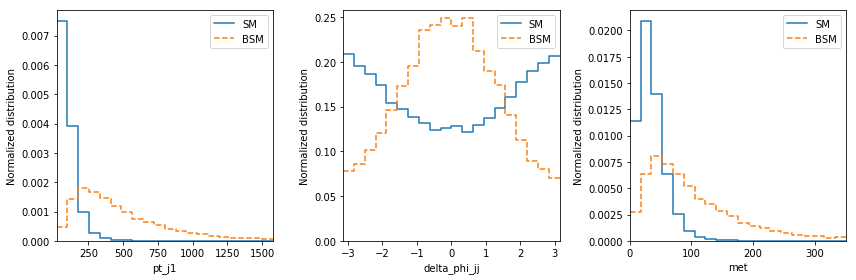

In [17]:
_ = plot_distributions(
    filename="data/lhe_data.h5",
    parameter_points=["sm", np.array([10.0, 0.0])],
    line_labels=["SM", "BSM"],
    uncertainties="none",
    n_bins=20,
    n_cols=3,
    normalize=True,
    sample_only_from_closest_benchmark=True,
)

## 7. Combine and shuffle different samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

This is generally good practice even if you use just one sample, since the events might have some inherent ordering (e.g. from sampling from different hypotheses). Later when we split the events into a training and test fraction, such an ordering could cause problems.

In [18]:
combine_and_shuffle(["data/lhe_data.h5"], "data/lhe_data_shuffled.h5")

17:04 madminer.sampling    DEBUG   Combining and shuffling samples
17:04 madminer.sampling    DEBUG   Copying setup from data/lhe_data.h5 to data/lhe_data_shuffled.h5
17:04 madminer.sampling    DEBUG   Loading samples from file 1 / 1 at data/lhe_data.h5, multiplying weights with k factor 1.0
17:04 madminer.sampling    DEBUG   Sampling benchmarks: [0 0 1 ... 0 2 1]
17:04 madminer.sampling    DEBUG   Combined sampling benchmarks: [0 0 1 ... 0 2 1]
17:04 madminer.sampling    DEBUG   Recalculated event numbers per benchmark: [49991 10000 10000 10000 10000     0], background: 0
